In [1]:
import numpy as np
from scipy import integrate, linalg
import qutip as q
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.linalg import expm
from tqdm import tqdm
from matplotlib import cm
import matplotlib as mpl
import pickle
import qutip_qip.operations as ops
from RIPV_import import *
from RIPV_core import *
import qutip_qip as qip
import time
import colorcet as cc

from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from typing import Union
from mpl_toolkits.mplot3d.axes3d import Axes3D


plt.rcParams['figure.figsize'] = (3, 2)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
np.set_printoptions(precision=3, linewidth=500, suppress=False)

In [3]:
TIME_STAMP = 0
def timerStart():
    global TIME_STAMP
    TIME_STAMP = time.time()

def timer(msg=''):
    global TIME_STAMP
    TIME_STAMP_NEW = time.time()
    print(TIME_STAMP_NEW - TIME_STAMP, ':', msg)
    TIME_STAMP = TIME_STAMP_NEW

In [4]:
class HaiPulse:
    def __init__(self, tlist: tf.Tensor, envolope=tf.sin) -> None:
        self.tlist = tlist
        self.envolope = envolope
    
    def fromParams(self, p: tf.Tensor) -> tf.Tensor:
        """
        p: Tensor[2n+1,]
        where p[:n+1] are amplitudes
        p[n+1:] are phases
        """
        t = self.tlist
        T = t[-1] - t[0]
        n = (p.shape[0] - 1) // 2

        a, phi = p[:n+1], p[n+1:]
        j = tf.range(1.0, n+1, dtype=tf.float64)  # j = 1, ..., n

        t = tf.expand_dims(t, axis=0)       # t dim   [1, len_t]
        j = tf.expand_dims(j, axis=1)       # j dim   [n, 1]         where n = len_phi + len_a
        phi = tf.expand_dims(phi, axis=1)   # phi dim [n, 1] 
        a = tf.expand_dims(a, axis=1)       # a dim   [n + 1, 1]

        components = a[1:] * tf.cos(2 * np.pi * j * t / T + phi)

        pulse = (a[0] + tf.reduce_sum(components, axis=0)) * self.envolope(t / T * np.pi)
        pulse = tf.squeeze(pulse)
        pulse = tf.cast(pulse, tf.complex128)
        return pulse

In [5]:
class HaiTwoPulses(HaiPulse):
    def __init__(self, tlist: tf.Tensor, paramNumber: int, envolope=tf.sin) -> None:
        super().__init__(tlist, envolope=envolope)
        self.paramNumber = paramNumber
    
    def fromParams(self, p: tf.Tensor) -> tf.Tensor:
        halfL = self.paramNumber
        p1, p2 = p[:halfL], p[halfL:]
        pulse1 = super().fromParams(p1)
        pulse2 = super().fromParams(p2)
        return [pulse1, pulse2]

c:\Users\neohu\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1062: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


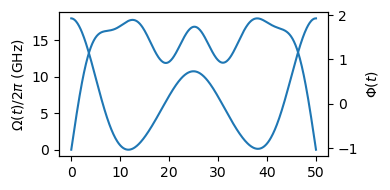

(2.2627412540057255+0j)


In [167]:
Ω = np.array([0.624, 0.484, 0.193, 0.070, 0.073, 0.005, 0.013, 0.003, -0.070])
Φ = np.array([0.083, 0.362, 1.174, 0.237, 0.074, 0.022, 0.017, 0.011, -0.037])

t = np.linspace(0, 50, 501)
hai = HaiPulse(t)
pulse_Omega = hai.fromParams(Ω)
pulse_Phi = hai.fromParams(Φ, envolope=lambda x: 1)

plt.figure(figsize=(4, 2))
plt.plot(t, pulse_Omega * 50)# / np.pi / 2)
plt.ylabel('$\Omega(t) / 2\pi$ (GHz)')
# plt.plot(t, pulse_Phi)
ax2 = plt.gca().twinx()
ax2.plot(t, pulse_Phi)
ax2.set_ylabel('$\Phi(t)$')
# plt.yticks([-.04, 0, .04, .08])
plt.tight_layout()
plt.show()

print(integrate.simpson(pulse_Omega / 2, x=t) / np.pi)


In [306]:
pulse_x_load = np.loadtxt(r'..\RCP_data\RCP_1_pi_all_Omega_x.csv')
pulse_y_load = np.loadtxt(r'..\RCP_data\RCP_1_pi_all_Omega_y.csv')

H = q.QobjEvo([
    [q.sigmax(), pulse_x_load / 2],
    [q.sigmay(), pulse_y_load / 2],
], tlist=t)
Ulist = q.propagator(H, t)
Ulist[-1].logm() / np.pi * 1j

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 8.8233199e-06-4.5639804e-07j  5.0020842e-01-4.9547355e-04j]
 [ 5.0020842e-01+4.9547355e-04j -8.8233199e-06-4.5639804e-07j]]

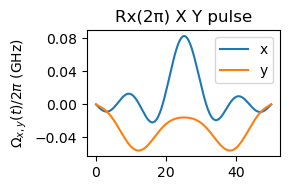

In [164]:
Ωx = np.array([0.007, -0.236, 0.032, -0.250, 0.008, -0.601, -0.029])
Ωy = np.array([-0.327, -0.127, 0.167, 0.066, 0.035, -0.079, -0.096])

t = np.linspace(0, 50, 501)
hai = HaiPulse(t)
pulse_x = tf.cast(hai.fromParams(Ωx), tf.float64)
pulse_y = tf.cast(hai.fromParams(Ωy), tf.float64)

Omega = np.sqrt(pulse_x ** 2 + pulse_y ** 2)
Phi = np.arccos(pulse_x)

plt.plot(t, pulse_x / np.pi / 2, label='x')
plt.plot(t, pulse_y / np.pi / 2, label='y')
# ax2 = plt.gca().twinx()
# ax2.plot(t, pulse_y)
plt.ylabel('$\Omega_{x,y}(t) / 2\pi$ (GHz)')
plt.yticks([-.04, 0, .04, .08])
plt.title("Rx(2π) X Y pulse")
plt.legend()
plt.tight_layout()
plt.show()

In [299]:
pulse_x, pulse_y = pulse_Omega * np.cos(pulse_Phi), pulse_Omega * np.sin(pulse_Phi)
H = q.QobjEvo([
    [q.sigmax(), np.array(pulse_x) / 2],
    [q.sigmay(), np.array(pulse_y) / 2],
], tlist=t)
Ulist = q.propagator(H, t)
Ulist[-1].logm() / np.pi

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-5.1837423e-08+7.4100723e-04j  4.9620268e-04-7.4874736e-01j]
 [-4.9620268e-04-7.4874736e-01j -5.1837423e-08-7.4100723e-04j]]

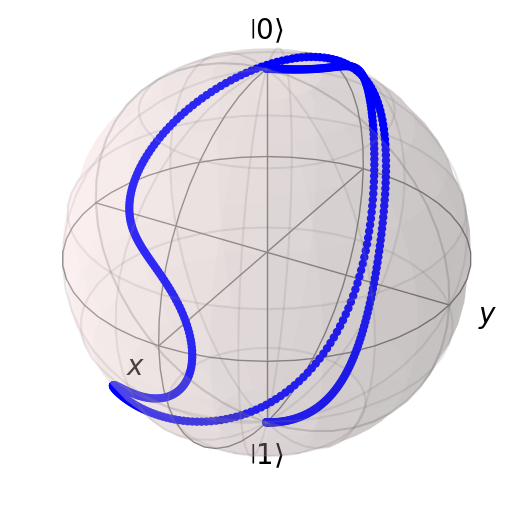

In [163]:
%matplotlib inline
# psi0 = q.Qobj([[1], [1j]]) / np.sqrt(2)
psi0 = q.basis(2, 0)
psilist = [U * psi0 for U in Ulist]
bloch = q.Bloch()
points = q.expect([X, Y, Z], psilist)
bloch.add_points(points)
bloch.show()

In [65]:
def removeGlobalPhase(op: q.Qobj):
    return op / (op[0,0] / np.abs(op[0,0]))

In [184]:
someRx = 1j * ops.rx(2*np.pi).logm() * 2#/ np.pi * 2
# removeGlobalPhase(someRx)
someRx

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-3.1918006-1.3540502j  3.0913847-1.3540502j]
 [ 9.4749859+1.3540502j  3.1918006+1.3540502j]]

In [51]:
def angleXYZ(H: q.Qobj):
    angles = []
    for σ in (q.sigmax(), q.sigmay(), q.sigmaz()):
        angle = (H.dag() * σ).tr() / 2
        angles.append(angle)
    return np.array(angles)

In [53]:
X, Y, Z, PI = q.sigmax(), q.sigmay(), q.sigmaz(), np.pi
x, y, z = 1.2, 1, 4.2  # After normalization: θ*x, θ*y, θ*z = 1.2, 1, 4.2
θ = np.linalg.norm([x,y,z])
x, y, z = x/θ, y/θ, z/θ  # Now [x,y,z] is normalized
U = (-1j * θ/2 * (x * X + y * Y + z * Z)).expm()
H = 1j * U.logm()
H, angleXYZ(H), np.array([x, y, z]) * (θ/2)

(Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 2.1-2.63677968e-16j  0.6-5.00000000e-01j]
  [ 0.6+5.00000000e-01j -2.1-1.11022302e-16j]],
 array([0.6-1.11022302e-16j, 0.5+5.55111512e-17j, 2.1+7.63278329e-17j]),
 array([0.6, 0.5, 2.1]))

## Control model

In [48]:
def logm(A):
    e, v = tf.linalg.eig(A)
    e = tf.linalg.diag(tf.math.log(e))
    return tf.matmul(v, tf.matmul(e, tf.linalg.adjoint(v)))

In [49]:
class XYControlModel:
    """
    This model assumes:
        control: X, Y
        noise:   X, Y, Z
    Hamiltonian:
        H = H_sys + H_c(t) + H_n
        H_c = ∑_i pulse_i * H_c_i
        H_n = ∑_i H_n_i
    """
    def __init__(self, tlist, paramsTo2Pulses, H_sys=0) -> None:
        X, Y, Z, I, OX = q.sigmax(), q.sigmay(), q.sigmaz(), q.identity(2), q.tensor
        X, Y, Z, I = [tf.constant(op.full()) for op in (X, Y, Z, I)]
        self.tlist = tlist
        self.dt = (tlist[-1] - tlist[0]) / len(tlist)
        self.H_sys = H_sys
        self.H_c_terms = [X, Y]
        self.H_n_terms = [X, Y, Z]
        self.paramsToPulses = paramsTo2Pulses

    def anglesAndRobs(self, A):
        """
        This function implements `costAndConstraint`:
            f(A) -> {x, cost, cons, ...}
        """
        X, Y, Z, I, OX = q.sigmax(), q.sigmay(), q.sigmaz(), q.identity(2), q.tensor
        X, Y, Z, I = [tf.constant(op.full()) for op in (X, Y, Z, I)]

        pulses = self.paramsToPulses(A)
        pulsesBy2 = [p/2 for p in pulses]
        H_c = construct_H_c(pulsesBy2, self.H_c_terms)
        
        H_sc_t = self.H_sys + H_c
        U_sc_t = propagator_of_Ht(H_sc_t, dt=self.dt)

        M1_t_list = []
        for H_n in self.H_n_terms:
            H_I_t = interaction_picture(H_n, U_sc_t)
            # M1_t = simpleCumulativeIntegral(H_I_t, I, self.tlist)
            M1 = simpleIntegral(H_I_t, x=self.tlist)
            M1_t = [M1]
            M1_t_list.append(M1_t)

        H_final = 1j * logm(U_sc_t[-1])
        # print(H_final, tf.linalg.expm(H_final))
        # H_final = 1j * tf.linalg.logm(U_sc_t[-1])
        # print(H_final, tf.linalg.expm(H_final))
        thetas = []
        for σ in (X, Y, Z):
            theta = tf.linalg.trace(tf.linalg.adjoint(σ) @ H_final)
            thetas.append(theta)
    
        R = [tf.norm(M1_t[-1]) for M1_t in M1_t_list]
        R = R + thetas[1:]  # R = [Rx, Ry, Rz, θy, θz]
        # R = tf.expand_dims(R, 0)
        result = {
            'cost': thetas[0],  # cost = θx
            'cons': R,
            # 'H_I_t': H_I_t,
            # 'M1_t': M1_t,
        }
        return result

In [50]:
Ωx = np.array([0.007, -0.236, 0.032, -0.250, 0.008, -0.601, -0.029])
Ωy = np.array([-0.327, -0.127, 0.167, 0.066, 0.035, -0.079, -0.096])
pinit = np.concatenate([Ωx, Ωy])

t = np.linspace(0, 50, 501)
hai2 = HaiTwoPulses(t, paramNumber=len(Ωx))

init_XYpulses = hai2.fromParams(pinit)

xyModel = XYControlModel(t, hai2.fromParams)
xyModel.anglesAndRobs(pinit)

{'cost': <tf.Tensor: shape=(), dtype=complex128, numpy=(3.1381047175057146-2.4424906541753444e-15j)>,
 'cons': [<tf.Tensor: shape=(), dtype=complex128, numpy=(0.2551430065903447-1.6743232531607962e-19j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.6096645632619867-1.9264265137310467e-18j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.5642224217389412+2.878941763145768e-21j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.009277311230005645-2.220446049250313e-16j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(0.00030343663649950883+9.442600652297187e-20j)>]}

In [382]:
# testU = tf.constant(
#     qip.operations.rz(np.pi).full()
#     # [[pow(np.e, np.pi * 1j), 0], [0, pow(np.e, np.pi * 1j)]]
# )
# testI = tf.constant(q.identity(2).full())

# # with tf.GradientTape() as tape:
# # with tf.device('/CPU:0'):  # Force TensorFlow to use CPU for this block
# #     logu = tf.Variable([[0,0], [0,0]], dtype=tf.complex128)
# #     timerStart()
# #     UmItok = (testU - testI)
# #     for k in range(1, 100):
# #         term = pow(-1, k+1) / k * UmItok
# #         logu.assign_add(term)
# #         UmItok = UmItok @ (testU - testI)
# #     timer()

# logu = logm(testU)
# print(1j * logu)
# logu = tf.linalg.logm(testU)
# print(1j * logu)
# print(tf.linalg.expm(logu))
# print(testU)

In [ ]:
result = gradientOrthogonalVariation(
    pinit,
    xyModel.anglesAndRobs,
    iters=int((2 * np.pi) / 0.001 + 10),
    costStep=0.001,
    deviceID='/GPU:0',
)

In [527]:
with open(r'.\data\XYcontrolXYZnoise\result_PIto2PI.npz', mode='rb') as f:
    result_PIto2PI = pickle.load(f)
with open(r'.\data\XYcontrolXYZnoise\result_PIto0.npz', mode='rb') as f:
    result_PIto0 = pickle.load(f)

### Merge results

Result in $[0, \pi]$ + result in $[\pi, 2\pi]$ $\to$ result in $[0, 2\pi]$

In [593]:
# result_PIto2PI['cost'] = [-c/2 for c in result_PIto2PI['cost']]

In [597]:
# # Merge two results into one
# result_Neg0to2PI = {}
# for key in result_PIto0.keys():
#     if key == 'itersCount':
#         continue
#     data_PIto2PI = result_PIto2PI[key][:-5]
#     data_0toPI = result_PIto0[key][:0:-1]
#     data_all = data_0toPI + data_PIto2PI
#     result_Neg0to2PI[key] = data_all
# result_Neg0to2PI['itersCount'] = result_PIto0['itersCount'] + result_PIto2PI['itersCount']-5 
# result_Neg0to2PI.keys()

dict_keys(['x', 'cost', 'cons', 'itersCount'])

In [617]:
# with open(r'.\data\XYcontrolXYZnoise\result_PIto2PI.npz', mode='wb') as f:
#     pickle.dump(result_PIto2PI, f)

### Check result

Check result in $[0, 2\pi]$

In [6]:
with open(r'.\data\XYcontrolXYZnoise\result_Neg0to2PI.pickle', mode='rb') as f:
    result_Neg0to2PI = pickle.load(f)

In [7]:
thetas = np.array(result_Neg0to2PI['cost'])

c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


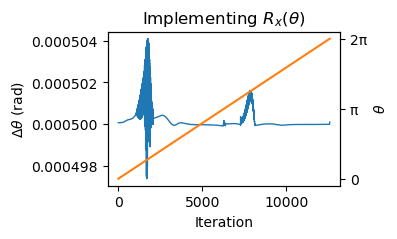

In [61]:
%matplotlib inline
plt.title(r'Implementing $R_x(\theta)$')
plt.plot(np.diff(thetas), 'C0', linewidth=1)
plt.ylabel(r'$\Delta \theta$ (rad)')
plt.xlabel('Iteration')
ax_y2 = plt.gca().twinx()
ax_y2.plot(thetas, color='C1')
ax_y2.set_yticks([0, 1*np.pi, 2*np.pi], labels='0 π 2π'.split())
ax_y2.set_ylabel(r'$\theta$')
plt.show()

In [286]:
np.diff([1, 2, 3, 4, 5])

array([1, 1, 1, 1])

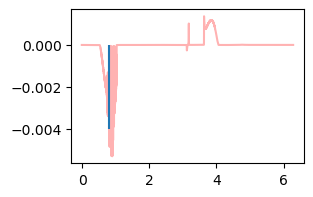

In [312]:
susceptX = np.array([Rxyzθyz[0] for Rxyzθyz in Rxyzθyz_list])
diff = lambda y: np.diff(y)
sel = range(0, len(susceptX) - 100, 1)

sometheta, someDDtheta = thetas[sel][1:-1], diff(diff(susceptX[sel]))
# plt.plot(sometheta, someDDtheta)
index = np.argwhere(someDDtheta[:5000] > 0.0003)
index = index[[0, -1]]

plt.plot(thetas[:-1], np.diff(susceptX), color='r', alpha=0.3)
plt.vlines([np.pi/4], ymin=-0.004, ymax=0)
plt.show()

c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


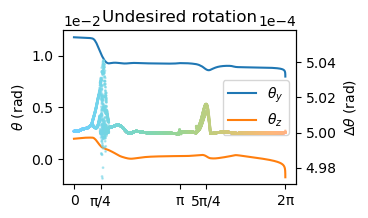

c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


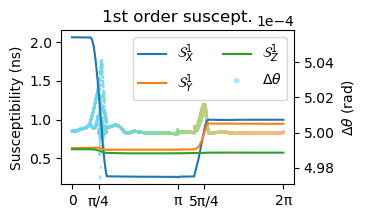

In [8]:
%matplotlib inline
# Check rotation on σy, σz
Rxyzθyz_list = result_Neg0to2PI['cons']
Rxyz_list = [Rxyzθyz[:3] for Rxyzθyz in Rxyzθyz_list]
θyz_list = [Rxyzθyz[-2:] for Rxyzθyz in Rxyzθyz_list]

cmap = cc.cm.CET_I2

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lines = ax1.plot(thetas, θyz_list, label=r'$\theta_y$ $\theta_z$'.split())
# lines += ax2.plot(thetas[1:], np.diff(thetas), 'C4',
#                   label=r'$\Delta\theta$', linewidth=1, alpha=.5)
every = 1
scatted = ax2.scatter(thetas[1::every], np.diff(thetas)[::every], c=thetas[1::every],
                  label=r'$\Delta\theta$', marker='o', s=1, alpha=.5, cmap=cmap)
ax1.set_xticks([0, np.pi/4, 1*np.pi, 5*np.pi/4, 2*np.pi], labels='0 π/4 π 5π/4 2π'.split())
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax1.set_ylabel(r'$\theta$ (rad)')
ax2.set_ylabel(r'$\Delta\theta$ (rad)')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylim(ymax=5.058e-4)

ax1.legend(lines, [l.get_label() for l in lines], loc=0, markerscale=3)
ax1.set_title('Undesired rotation')
# plt.savefig(r'.\data\XYcontrolXYZnoise\theta_yz.pdf',
#             bbox_inches='tight')
plt.show()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lines = ax1.plot(thetas, Rxyz_list, label=[r'$\mathcal{S}^1_{'+s+'}$' for s in 'X Y Z'.split()])
# lines += ax2.plot(thetas[1:], np.diff(thetas), 'C4',
#                   label=r'$\Delta\theta$', linewidth=1, alpha=.5)
every = 1
scatted = ax2.scatter(thetas[1::every], np.diff(thetas)[::every], c=thetas[1::every],
                  label=r'$\Delta\theta$', marker='o', s=1, alpha=.5, cmap=cmap)
lines.append(scatted)
ax1.set_ylabel('Susceptibility (ns)')
ax2.set_ylabel(r'$\Delta\theta$ (rad)')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylim(ymax=5.058e-4)

ax1.legend(lines, [l.get_label() for l in lines], loc=1, ncol=2, markerscale=3)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.set_frame_on(False)
ax1.set_title('1st order suscept.')
ax1.set_xticks([0, np.pi/4, 1*np.pi, 5*np.pi/4, 2*np.pi], labels='0 π/4 π 5π/4 2π'.split())
# plt.savefig(r'.\data\XYcontrolXYZnoise\S1_xyz.pdf',
#             bbox_inches='tight')
plt.show()

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗

Plottings of R_xyz and θ_yz are moved to [RIPV-Plotting.ipynb](./RIPV-Plotting.ipynb) file.

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗

In [51]:
t = np.linspace(0, 50, 501)
infid_list = []
chosenIndices = list(range(0, len(result_Neg0to2PI['x']), 10))
for k in tqdm(chosenIndices):
    pulse_x, pulse_y = hai2.fromParams(result_Neg0to2PI['x'][k])
    H = q.QobjEvo([
        [q.sigmax(), np.array(pulse_x) / 2],
        [q.sigmay(), np.array(pulse_y) / 2],
    ], tlist=t)
    U_final = q.propagator(H, t)[-1]
    infid_list.append(1 - matrix_similarity(U_final, qip.operations.rx(thetas[k]).full()))

100%|██████████| 1259/1259 [00:35<00:00, 35.90it/s]


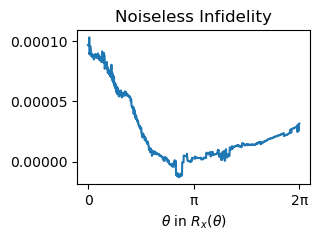

In [67]:
plt.plot(thetas[chosenIndices], infid_list)
plt.xticks([0, 1*np.pi, 2*np.pi], labels='0 π 2π'.split())
plt.xlabel(r'$\theta$ in $R_x(\theta)$')
plt.title('Noiseless Infidelity')
plt.show()

### Plot fidelity vs noise

In [110]:
from typing import List
from numpy.typing import NDArray


def noiseFid_XYcontrol(
        tlist: NDArray,
        pulses: List[NDArray],
        theta_x: float,
        maxRelNoise=0.2,
        noiseOp=q.sigmaz(),
        progressBar=True,
        samplePoints=101,
    ):
    pulses = np.array(pulses).real
    maxAmp = np.max(np.abs(pulses))

    gateIdeal = (-1j * q.sigmax() * theta_x/2).expm().full()

    deltaPercentList = np.linspace(-maxRelNoise, maxRelNoise, samplePoints)
    fidelityList = []
    if progressBar:
        from tqdm import tqdm
    else:
        tqdm = lambda x: x
    for deltaPercent in tqdm(deltaPercentList):
        delta = deltaPercent * maxAmp
        H = q.QobjEvo([
            delta / 2 * noiseOp,
            [q.sigmax(), pulses[0] / 2],
            [q.sigmay(), pulses[1] / 2],
        ], tlist=tlist)
        Ulist = q.propagator(H, tlist)
        fidelityList.append(matrix_similarity(Ulist[-1], gateIdeal))
    return deltaPercentList, fidelityList


In [97]:
# Load RIPV result
with open(r'.\data\XYcontrolXYZnoise\result_Neg0to2PI.npz', mode='rb') as f:
    result_Neg0to2PI = pickle.load(f)

In [ ]:

chosenIndices = list(range(0, len(result_Neg0to2PI['x']), 20)) + [len(result_Neg0to2PI['x'])-1,]
XYZnoiseFid_list = []
for k in tqdm(chosenIndices):
    noiseFid_xyz = []
    for op in (q.sigmax(), q.sigmay(), q.sigmaz()):
        noiseFid = noiseFid_XYcontrol(
            t, hai2.fromParams(result_Neg0to2PI['x'][k]),
            theta_x=result_Neg0to2PI['cost'][k],
            maxRelNoise=0.2,
            noiseOp=op,
            progressBar=False,
            samplePoints=201,
        )
        noiseFid_xyz.append(noiseFid)
    theta = float(result_Neg0to2PI['cost'][k])
    data = {
        'XnoiseFid': noiseFid_xyz[0],
        'YnoiseFid': noiseFid_xyz[1],
        'ZnoiseFid': noiseFid_xyz[2],
        'RxAngle': theta,
        'index': k,
    }
    XYZnoiseFid_list.append(data)

# Write noise vs. fidelity data
with open(r'.\data\XYcontrolXYZnoise\noiseVSFid.pickle', mode='wb') as f:
    pickle.dump(XYZnoiseFid_list, f)

In [7]:
with open(r'.\data\XYcontrolXYZnoise\noiseVSFid.pickle', mode='rb') as f:
    XYZnoiseFid_list = pickle.load(f)

In [41]:
XYZnoiseFid_data = {}
XYZnoiseFid_data['noisePercent'] = np.array(XYZnoiseFid_list[0]['XnoiseFid'][0])
XYZnoiseFid_data['fidUnderNoise'] = {
    'X': np.array([data['XnoiseFid'][1] for data in XYZnoiseFid_list]),
    'Y': np.array([data['YnoiseFid'][1] for data in XYZnoiseFid_list]),
    'Z': np.array([data['ZnoiseFid'][1] for data in XYZnoiseFid_list]),
}
XYZnoiseFid_data['angle'] = np.array([data['RxAngle'] for data in XYZnoiseFid_list])
XYZnoiseFid_data['indexInExperiment'] = np.array([data['index'] for data in XYZnoiseFid_list])
XYZnoiseFid_data['README'] = """Instruction of This Data

This data has following keys:
'noisePercent' is 1d array, stores shared noise strength relative to Ω_max.
'fidUnderNoise' is dict with keys 'X', 'Y', 'Z';
    'X' is a list of fid arrays, each array relates to Rx('angle'[k]) under X noise;
    same for 'Y', 'Z'.
'angle' is array, stores k-th angle corresponding to 'fidUnderNoise'['X'][k].
'indexInExperiment' is array, index in the result of experiment for Rx(0)->Rx(2π).

To plot Rx(θ) 's Xnoise-fid graph:
1. find 'angle'[k]==θ,
2. plot with x=data['noisePercent'], y=data['fidUnderNoise']['X'][k].
"""

In [76]:
# with open(r'.\data\XYcontrolXYZnoise\XYZnoiseFid_data.pickle', mode='wb') as f:
#     pickle.dump(XYZnoiseFid_data, f)

In [8]:
with open(r'.\data\XYcontrolXYZnoise\XYZnoiseFid_data.pickle', mode='rb') as f:
    print(pickle.load(f)['README'])

Instruction of This Data

This data has following keys:
'noisePercent' is 1d array, stores shared noise strength relative to Ω_max.
'fidUnderNoise' is dict with keys 'X', 'Y', 'Z';
    'X' is a list of fid arrays, each array relates to Rx('angle'[k]) under X noise;
    same for 'Y', 'Z'.
'angle' is array, stores k-th angle corresponding to 'fidUnderNoise'['X'][k].
'indexInExperiment' is array, index in the result of experiment for Rx(0)->Rx(2π).

To plot Rx(θ) 's Xnoise-fid graph:
1. find 'angle'[k]==θ,
2. plot with x=data['noisePercent'], y=data['fidUnderNoise']['X'][k].



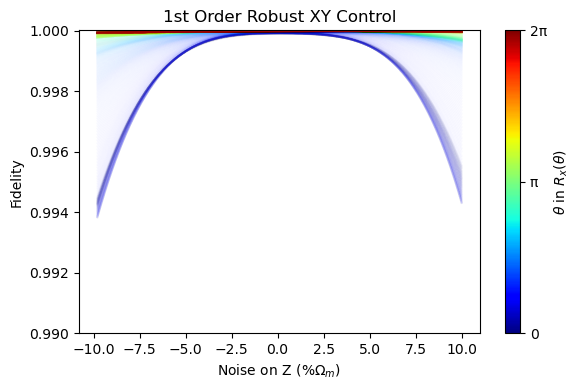

In [79]:
cmap = cm.jet
colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

_δm = 0.1
needToShow = np.nonzero(np.logical_and(
    -_δm < XYZnoiseFid_data['noisePercent'], XYZnoiseFid_data['noisePercent'] < _δm
))[0]

opname = 'Z'

plt.figure(figsize=(6, 4))
for k in range(len(XYZnoiseFid_data['angle'])):
   plt.plot(
      XYZnoiseFid_data['noisePercent'][needToShow] * 100,
      XYZnoiseFid_data['fidUnderNoise'][opname][k][needToShow],
      c=cmap(colorNormalizer(XYZnoiseFid_data['angle'][k])),
      alpha=.02
   )
plt.ylim(bottom=1-1e-2, top=1+1e-5)
plt.ylabel('Fidelity')
plt.xlabel(rf'Noise on {opname} (%$\Omega_m$)')
plt.title('1st Order Robust XY Control')
cbar = plt.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=plt.gca())
cbar.set_label(r'$\theta$ in $R_x(\theta)$')  # Set the label for the colorbar
cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
cbar.set_ticklabels('0 π 2π'.split())  # Set custom tick labels
plt.tight_layout()
plt.savefig(rf'.\data\XYcontrolXYZnoise\{opname}noiseFid.png')
%matplotlib inline
plt.show()

### Plot pulse and error curves

In [7]:
# Load RIPV result
with open(r'.\data\XYcontrolXYZnoise\result_Neg0to2PI.pickle', mode='rb') as f:
    result_Neg0to2PI = pickle.load(f)
result_Neg0to2PI.keys()

dict_keys(['x', 'cost', 'cons', 'itersCount', 'tlist'])

In [9]:
result = result_Neg0to2PI

In [56]:
%matplotlib qt

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

x_list = result['x']
tlist = result['tlist']
LENGTH = len(x_list)
numOfParams = 9

hai2 = HaiTwoPulses(tlist, numOfParams)
cmap = cm.rainbow  # Good choices: brg, 
colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))

for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
    A = x_list[index]
    pulse_x, pulse_y = hai2.fromParams(A)
    pulse_x, pulse_y = np.real(pulse_x), np.real(pulse_y)
    angle_x = np.real(result['cost'][index])
    ax.plot(
        np.ones(tlist.shape) * angle_x, tlist, pulse_x,
        color=cmap(colorNormalizer(angle_x)),
        alpha=1 if index in highlighted else 0.2
    )
# plt.axis('equal')
# plt.legend()
# plt.savefig('data/piOver3_R1const/error_curves.png')
ax.set_box_aspect((2.5, 1, 1))
ax.set_xlabel('\n\n')
ax.set_ylabel('Time (ns)')
ax.set_zlabel('\nAmplitude (GHz)')
tickLabels = [0, 25, 50]
yticks = [int(t) for t in tickLabels]
ax.set_yticks(yticks, tickLabels)
# fig.constrained_layout()
# plt.savefig(r'.\data\XYcontrolXYZnoise\try.png', bbox_inches='tight')
fig.tight_layout()
fig.show()

C:\Users\neohu\AppData\Local\Temp\ipykernel_28416\1133956402.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


## Functions for plotting

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗

All plotting codes are moved to [RIPV-Plotting.ipynb](./RIPV-Plotting.ipynb) file.

❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗